# J-Quants API 株式市場分析デモ

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AlpacaDB/jquants-api-sample/blob/main/jquants_api_sample.ipynb)

本デモでは以下のユーザーを想定しています。

* Python / Pandas / Matplotlib / Seaborn についての知識を有していること
* J-Quants API リフレッシュトークンを取得して Google Drive に保存していること
    * ※ リフレッシュトークンの代わりに jquants-api.toml にメールアドレスとパスワードを設定しておく方法もございます
* Google Driveにアクセス可能であること
* (Optional) Google Cloud Storage を使用可能であること

本デモで使用している jquants-api-client (jquantsapi) は以下のリポジトリで公開されております。

https://github.com/J-Quants/jquants-api-client-python

In [2]:
import os
from datetime import datetime

import japanize_matplotlib
import jquantsapi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# pandas の表示制限を調整します
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)

## データ保存用ディレクトリ設定

J-Quants APIから取得したデータを保存しておくためのディレクトリを設定します。

J-Quants APIから毎回全データを取得するのではデータ取得のために時間がかかってしまうため、取得したデータを保存しておいて必要な最新データのみを J-Quants API から取得します。
加えて、分析に必要な中間ファイルや結果ファイルの保存にも使用します。

データ量が多くなければ Google Drive で十分ですが、データ量が多くなってきた場合は Cloud Storage を使用するとよいでしょう。

### データ保存用ディレクトリへのパスを設定

In [4]:
STORAGE_DIR_PATH = "/workspace/marketdata"
os.makedirs(STORAGE_DIR_PATH, exist_ok=True)
STORAGE_DIR_PATH

'/workspace/marketdata'

## J-Quants API のリフレッシュトークン取得

※ 最新の jquants-api-client-python ではリフレッシュトークンの代わりに登録したメールアドレスおよびパスワードを使用することもできるようになりました。詳細は [jquants-api-client-python](https://github.com/J-Quants/jquants-api-client-python) を御覧ください。

J-Quants APIにアクセスするためには J-Quants API の Web サイトから取得できるリフレッシュトークンが必要になります。
取得したリフレッシュトークンを Google Drive に配置してから以下の作業をすすめます。

※ Google Drive 上のファイル経由でリフレッシュトークンを取り扱っているのは、このような公開の場でデモする際にリフレッシュトークンを画面上に露出させないためです。

※ リフレッシュトークンの有効期限は1週間となっているため、1週間ごとに再取得が必要になります。

In [5]:
REFRESH_TOKEN_FILE_PATH = "/workspace/jquantsapi-key.txt"

In [6]:
def get_refresh_token(refresh_token_file_path: str = REFRESH_TOKEN_FILE_PATH):
    with open(refresh_token_file_path, "r") as f:
        refresh_token = f.read()
    return refresh_token.rstrip().lstrip()

In [7]:
refresh_token = get_refresh_token()

## J-Quants API アクセスクライアント初期化

J-Quants API はシンプルな Web API 実装となっています。ここではjquants-api-clientライブラリを使用します。

* ラッパー群　J-Quants API の各APIエンドポイントに対応しています。
  * get_refresh_token
  * get_id_token
  * get_listed_info
  * get_listed_sections
  * get_prices_daily_quotes
  * get_indices_topix
  * get_markets_trades_spec
  * get_fins_statements
  * get_fins_announcement
* ユーティリティー群
  * 業種や市場区分一覧などを返します。
    * get_market_segments
    * get_17_sectors
    * get_33_sectors
  * 日付範囲を指定して一括でデータ取得して、取得したデータを結合して返すようなユーティリティーメソッドです。
    * get_list
    * get_price_all
    * get_statements_all

In [8]:
jqapi = jquantsapi.Client(refresh_token=refresh_token)
# # フレッシュトークンの代わりに以下のようにメールアドレスとパスワードを使用することも可能です
# my_mail_address:str = "*****"
# my_password: str = "*****"
# jqapi = jquantsapi.Client(mail_address=my_mail_address, password=my_password)

※ 最新の jquants-api-client-python では以下の方法でデータ取得のための認証を実施することができます。詳細は [jquants-api-client-python](https://github.com/J-Quants/jquants-api-client-python) を御覧ください。

1.   refresh_token パラメーター (本サンプル)
2.   mail_address および password パラメーター
3.   設定ファイル
4.   環境変数


## J-Quants APIから取得できるデータの確認

### 銘柄情報の取得

銘柄情報は個別に銘柄コードを指定して取得することと、日付を指定して一覧を取得することができます。

In [9]:
# 銘柄コードを指定して取得
df_list = jqapi.get_listed_info(code=8697)
df_list.head(2)

,Date,Code,CompanyName,Sector17Code,Sector17CodeName,Sector33Code,Sector33CodeName,ScaleCategory,MarketCode,MarketCodeName
0,2023-02-13,86970,日本取引所グループ,16,金融（除く銀行）,7200,その他金融業,TOPIX Large70,111,プライム


In [10]:
# 日付を指定して取得 (銘柄コードを指定することも可能です)
df_list = jqapi.get_listed_info(date_yyyymmdd="20170101")
df_list.head(2)

,Date,Code,CompanyName,Sector17Code,Sector17CodeName,Sector33Code,Sector33CodeName,ScaleCategory,MarketCode,MarketCodeName
0,2017-01-04,13010,極洋,1,食品,0050,水産・農林業,TOPIX Small 2,101,東証一部
1,2017-01-04,13050,ダイワ上場投信−トピックス,99,その他,9999,その他,-,109,その他


In [11]:
# 最新日付の全銘柄一覧を取得
df_list = jqapi.get_listed_info()
df_list.head(2)

,Date,Code,CompanyName,Sector17Code,Sector17CodeName,Sector33Code,Sector33CodeName,ScaleCategory,MarketCode,MarketCodeName
0,2023-02-13,13010,極洋,1,食品,0050,水産・農林業,TOPIX Small 2,111,プライム
1,2023-02-13,13050,ダイワ上場投信−トピックス,99,その他,9999,その他,-,109,その他


### セクター情報の取得

In [12]:
# APIから33業種を取得します
df_sectors = jqapi.get_listed_sections()
df_sectors.head(2)

,SectorCode,SectorName
33,0050,水産・農林業
5,1050,鉱業


In [13]:
# jquants-api-client に埋め込まれている33業種を取得します
df_33_sectors = jqapi.get_33_sectors()
df_33_sectors.head(2)

,Sector33Code,Sector33CodeName,Sector33CodeNameEnglish,Sector17Code
0,0050,水産・農林業,"Fishery, Agriculture & Forestry",1
1,1050,鉱業,Mining,2


In [14]:
# jquants-api-client に埋め込まれている17業種を取得します
df_17_sectors = jqapi.get_17_sectors()
df_17_sectors.head(2)

,Sector17Code,Sector17CodeName,Sector17CodeNameEnglish
0,1,食品,FOODS
9,10,情報通信・サービスその他,"IT & SERVICES, OTHERS"


### 市場区分の取得

In [15]:
# jquants-api-client に埋め込まれている市場区分を取得します
df_market = jqapi.get_market_segments()
df_market.head(2)

,MarketCode,MarketCodeName,MarketCodeNameEnglish
0,101,東証一部,1st Section
1,102,東証二部,2nd Section


### 銘柄/市場区分/セクターの確認

ここまで取得したデータを使用して簡単な確認を実施してみましょう。

In [16]:
# 全銘柄数
df_list.shape[0]

4247

<AxesSubplot: xlabel='MarketCodeName'>

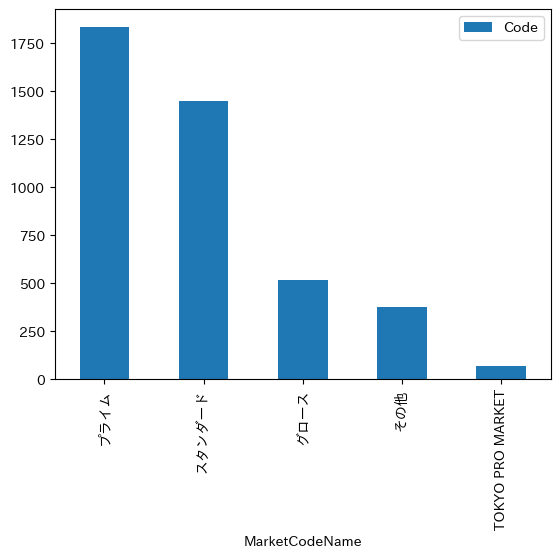

In [17]:
# 市場区分毎の銘柄数を確認
df_list.groupby("MarketCodeName")["Code"].count().sort_values(
    ascending=False
).to_frame().plot(kind="bar")

In [ ]:
# セクター毎の銘柄数を確認
df_list.groupby("Sector33CodeName")["Code"].count().sort_values(
    ascending=False
).to_frame().plot(kind="bar")

In [ ]:
# セクターおよび市場区分ごとの銘柄数確認
# ヒートマップで確認するためにデータを整形します。
df_tmp = (
    df_list.groupby(["Sector33CodeName", "MarketCodeName"])["Code"]
    .count()
    .to_frame()
    .reset_index()
    .pivot(index="Sector33CodeName", columns="MarketCodeName", values="Code")
    .fillna(0)
    .astype(int)[["プライム", "スタンダード", "グロース"]]
)
df_tmp.head(5)

In [ ]:
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(
    df_tmp,
    annot=True,
    fmt="d",
    cmap=sns.diverging_palette(230, 20, as_cmap=True),
    linewidths=0.5,
    ax=ax,
)

### 株価情報の取得

株価情報は2通りの取得方法が提供されています。それぞれの取得方法を確認してみましょう。

In [ ]:
# 日付を指定して取得
df_price = jqapi.get_prices_daily_quotes(date_yyyymmdd="20220517")
df_price.head(2)

In [ ]:
# 銘柄コードを指定して取得
df_price = jqapi.get_prices_daily_quotes(code=8697)
df_price.tail(2)

### 指数情報の取得

#### 日次の TOPIX 指数情報の取得

日付を指定して取得することも可能です。

In [ ]:
# 指定した期間のデータ
df_topix = jqapi.get_indices_topix(from_yyyymmdd="20221101", to_yyyymmdd="20221104")
df_topix

In [ ]:
# 全期間のデータ
df_topix = jqapi.get_indices_topix()
df_topix.head(2)

### マーケット情報の取得

#### 週次の投資部門別売買状況

日付を指定して取得する方法と、セクションを指定して取得する方法が提供されています。

In [ ]:
# 指定したセクションの指定した期間のデータ
df_markets_trades = jqapi.get_markets_trades_spec(section=jquantsapi.MARKET_API_SECTIONS.TSE1st, from_yyyymmdd="20190101", to_yyyymmdd="20190114")
df_markets_trades.tail(2)

In [ ]:
# 指定したセクションの全期間のデータ
df_markets_trades = jqapi.get_markets_trades_spec(section=jquantsapi.MARKET_API_SECTIONS.TSEPrime)
df_markets_trades.tail(2)

In [ ]:
# すべてのセクションの指定した期間のデータ
df_markets_trades = jqapi.get_markets_trades_spec(from_yyyymmdd="20190101", to_yyyymmdd="20190114")
df_markets_trades.tail(2)

In [ ]:
# すべてのセクションの全期間のデータ
df_markets_trades = jqapi.get_markets_trades_spec()
df_markets_trades.tail(2)

### 財務情報の取得

財務情報も日付を指定して取得する方法と、銘柄コードを指定して取得する方法が提供されています。

In [ ]:
# 日付を指定
df_fin = jqapi.get_fins_statements(date_yyyymmdd="20220629")
df_fin.head(2).T

In [ ]:
# 銘柄コードを指定
df_fin = jqapi.get_fins_statements(code=8697)
df_fin.tail(2).T

### 財務情報公表予定の取得

In [ ]:
df_fin_announcement = jqapi.get_fins_announcement()
df_fin_announcement.head(2)

## J-Quants API からのデータ取得と保存



J-Quants API から毎日データを取得して分析する環境を作るために、日次で必要なデータを取得していきます。

### 銘柄データの取得

以降の作業を容易にするために、市場区分やセクター情報を結合した銘柄リストを作成します。

In [ ]:
now = pd.Timestamp.now(tz="Asia/Tokyo")
if now.hour < 22:
    # データ更新時間前の場合は日付を1日ずらします。
    now -= pd.Timedelta(1, unit="D")
list_file = f"{STORAGE_DIR_PATH}/list_{now.strftime('%Y%m%d')}.csv.gz"
if not os.path.isfile(list_file):
    df_list = jqapi.get_list()
    df_list.to_csv(list_file, compression="gzip", index=False)
    print(f"save file: {list_file}")
else:
    print(f"file exists: {list_file}, loading")
    df_list = pd.read_csv(list_file, dtype="str")

In [ ]:
df_list.head(2)

### 株価データの取得

ここではロジックを簡易で済ませるために日次で必要な全データを取得しなおしています。
環境によって実行に2分ほどかかることがあります。

TODO: 未調整済み株価から調整済み株価の算出ロジックの実装

In [ ]:
now = pd.Timestamp.now(tz="Asia/Tokyo")
start_dt = now - pd.offsets.Week(6)
end_dt = now
if end_dt.hour < 19:
    # データ更新時間前の場合は日付を1日ずらします。
    end_dt -= pd.Timedelta(1, unit="D")
price_file = f"{STORAGE_DIR_PATH}/price_{start_dt.strftime('%Y%m%d')}_{end_dt.strftime('%Y%m%d')}.csv.gz"
if not os.path.isfile(price_file):
    df_p = jqapi.get_price_range(start_dt=start_dt, end_dt=end_dt)
    df_p.to_csv(price_file, compression="gzip", index=False)
    print(f"save file: {price_file}")
else:
    print(f"file exists: {price_file}, loading")
    df_p = pd.read_csv(price_file, dtype="str")
    df_p.loc[:, "Date"] = pd.to_datetime(df_p["Date"], format="%Y-%m-%d")
    

In [ ]:
df_p.tail(2)

### 財務データの取得

get_statements_all に cache_dir を指定すると、日次のデータをキャッシュとして保存しておくため、日次では必要なファイルのみを取得しています。

In [ ]:
now = pd.Timestamp.now(tz="Asia/Tokyo")
start_dt = now - pd.Timedelta(14, unit="D")
end_dt = now - pd.Timedelta(1, unit="D")
if end_dt.hour < 1:
    # データ更新時間前の場合は日付を1日ずらします。
    end_dt -= pd.Timedelta(1, unit="D")
statements_file = f"{STORAGE_DIR_PATH}/statements_{start_dt.strftime('%Y%m%d')}_{end_dt.strftime('%Y%m%d')}.csv.gz"
if not os.path.isfile(statements_file):
    cache_dir = f"{STORAGE_DIR_PATH}/raw_statements"
    os.makedirs(cache_dir, exist_ok=True)
    df_s = jqapi.get_statements_range(
        start_dt=start_dt, end_dt=end_dt, cache_dir=cache_dir
    )
    df_s.to_csv(statements_file, compression="gzip", index=False)
    print(f"save file: {statements_file}")
else:
    print(f"file exists: {statements_file}, loading")
    df_s = pd.read_csv(statements_file, dtype="str")
    df_s.loc[:, "DisclosedDate"] = pd.to_datetime(
        df_s["DisclosedDate"], format="%Y-%m-%d"
    )
    df_s.loc[:, "CurrentPeriodEndDate"] = pd.to_datetime(
        df_s["CurrentPeriodEndDate"], format="%Y-%m-%d"
    )
    df_s.loc[:, "CurrentFiscalYearStartDate"] = pd.to_datetime(
        df_s["CurrentFiscalYearStartDate"], format="%Y-%m-%d"
    )
    df_s.loc[:, "CurrentFiscalYearEndDate"] = pd.to_datetime(
        df_s["CurrentFiscalYearEndDate"], format="%Y-%m-%d"
    )
    df_s.sort_values("DisclosedUnixTime", inplace=True)

In [ ]:
df_s.head(2)

## J-Quants APIから取得したデータの分析

ここまでで日次で最新のデータを取得できるようになったため、ここからは取得したデータを使用して分析をしてみたいと思います。一例として注目されているセクターの移り変わりを分析してみたいと思います。

### プライム市場における各セクターの取引代金の変化率

セクターローテーションという言葉が示すように注目されているセクターは市場状況に応じて変化していきます。各セクターごとのリターンを算出して分析することが一般的ですが、ここではプライム市場において各セクターの取引代金が占める割合の変化を分析してみます。

In [ ]:
# 株価情報と銘柄情報を結合します
# Date 列が重複しているため df_list から削除して結合しています
df_work = pd.merge(df_p, df_list.drop(columns=["Date"]), how="inner", on=["Code"])
# 数字型に変換します
df_work.loc[:, "TurnoverValue"] = df_work["TurnoverValue"].astype(np.float64)
df_work.head(2)

In [ ]:
# プライム市場の過去5週のセクター別の取引額のしめる割合の推移を確認します
last_bday = (pd.Timestamp.now(tz="Asia/Tokyo") - pd.offsets.Week(6)).strftime(
    "%Y-%m-%d"
)
# データを絞り込みます
df = df_work.loc[
    (
        (
            # 営業日
            df_work["Date"]
            >= last_bday
        )
        & (
            # プライム市場
            df_work["MarketCode"]
            == "111"
        )
    )
].copy()

In [ ]:
# 週次でセクターごとの取引代金を集計してフォーマットを整えます
df_turnovervalue = (
    (
        df.groupby(["Sector33CodeName", pd.Grouper(key="Date", freq="W")])[
            ["TurnoverValue"]
        ].sum()
    )
    .reset_index()
    .pivot("Date", "Sector33CodeName", "TurnoverValue")
    .dropna()
)
# 週次で各セクターの割合を計算します
df_turnovervalue = df_turnovervalue.div(df_turnovervalue.sum(axis=1), axis=0)
# 割合の前週との変化率を計算します
df_turnovervalue = df_turnovervalue.pct_change().dropna()
# 日付範囲を区切ります
df_turnovervalue = df_turnovervalue.loc[df_turnovervalue.index[1:]]
# 日付の表示方法を変更します
df_turnovervalue.index = df_turnovervalue.index.strftime("%Y-%m-%d")
# 表示用に展開します
df_turnovervalue = df_turnovervalue.T
# 直近の増減でソートします
df_turnovervalue = df_turnovervalue.sort_values(
    df_turnovervalue.columns[-1], ascending=False
)
# 週次での増減を可視化します
df_turnovervalue.style.background_gradient(cmap="RdYlGn", axis=0)

本日のデモは以上となります。

J-Quants API を使用することで個人投資家の方々もご自身の観点で市場を分析することができるようになるかと思われます。今回は財務情報についてデータの取得のみで分析はしませんでしたが、J-Quants データ分析コンペティションで上位入賞した機械学習モデルは財務情報からも特徴量を抽出していますように、分析しがいのあるデータとなっております。

J-Quants API が登場することによって、個人投資家が使用可能な Google Colab や Google Cloud などのオンデマンドでの計算資源と組み合わせることで、データドリブンな意思決定をよりしやすい環境が見えてきました。

J-Quants API は現在ベータ版が公開されています。公式サイトにて運営事務局へのフィードバックも募集されていますので、本ノートブックが活発なディスカッションの一助となれば幸いでございます。

[J-Quatns公式サイト](https://jpx-jquants.com)